该笔记本实现**步骤4-6**

## Imports

In [6]:
import pandas as pd
import numpy as np

# 去除切片复制警告
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale = 2)

# 输入缺失值和缩放值
from sklearn.preprocessing import Imputer, MinMaxScaler

# 机器学习模型
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# 超参调试
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 

## Read in Data

In [7]:
# 将数据读取到dataframes
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# 显示数据大小
print('训练特征数据集大小：', train_features.shape)
print('测试特征数据集大小：', test_features.shape)
print('训练标签数据集大小：', train_labels.shape)
print('测试标签数据集大小：', test_labels.shape)

训练特征数据集大小： (6622, 64)
测试特征数据集大小： (2839, 64)
训练标签数据集大小： (6622, 1)
测试标签数据集大小： (2839, 1)


In [8]:
train_features.head(10)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

In [9]:
train_labels.head(10)

,score
0,16.0
1,53.0
2,99.0
3,35.0
4,91.0
5,94.0
6,92.0
7,50.0
8,78.0
9,48.0


Text(0.5,1,'能源之星分数分布')

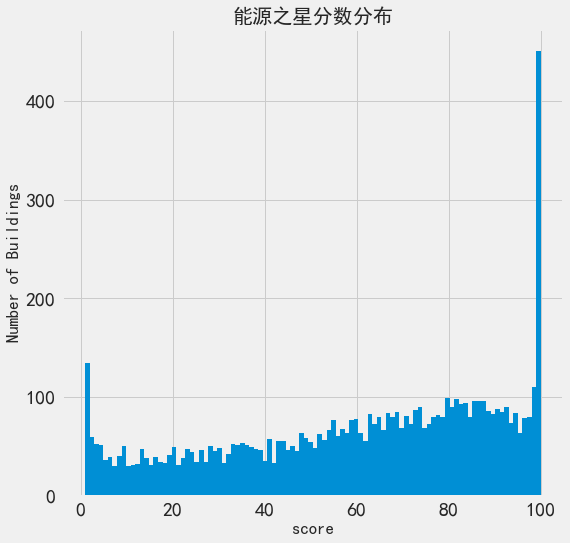

In [10]:
# 分数分布
figsize(8, 8)
# 正常显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins=100)
plt.xlabel('score')
plt.ylabel('Number of Buildings')
plt.title('能源之星分数分布')

# Evaluating and Comparing Machine Learning Models
*  mean absolute error
*  average of 25 points（baseline）

## Imputing Missing Values
**缺失值插补**：列的**中位数**填充缺失值

为了避免**数据泄漏**（来自测试集的信息“泄漏”到训练过程中），测试集中的缺失值用训练集中相应列的中值填充。

In [11]:
# 创建imputer用以中值填充
imputer = Imputer(strategy='median')

# 在训练特征集上训练
imputer.fit(train_features)

# 转换训练集和测试集
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

print('训练特征集上的缺失值：', np.sum(np.isnan(X)))
print('测试特征集上的缺失值：', np.sum(np.isnan(X_test)))

训练特征集上的缺失值： 0
测试特征集上的缺失值： 0


In [12]:
# 确保所有值都是有限的
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Scaling Features
**特征缩放**：每个特征具有不同的单位，对特征进行标准化，以使单位不影响算法。

线性回归和随机森林不需要特征缩放，但其他方法（例如支持向量机和k最近邻）需要特征缩放，因为它们考虑了观测之间的欧几里德距离。因此，在比较多个算法时，最佳做法是特征缩放。

**特征缩放**方法：
* 每个值减去特征的平均值并**除以**特征的标准偏差。这称为**标准化**，特征分布均值为0和标准差为1。
* 每个值减去特征的最小值并**除以**特征的最大值减去最小值（范围）。确保特征的所有值都在0到1之间，并称为**缩放到范围或标准化**。

In [13]:
# 创建0-1的缩放目标
scaler = MinMaxScaler(feature_range=(0, 1))

# 在训练集训练
scaler.fit(X)

# 转换训练集和测试集
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [14]:
# 将y转换成一维数组（向量）
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Models to Evaluate
五种机器学习模型：
* 线性回归（LR）
* 支持向量机回归（SVMR）
* 随机森林回归（RFR）
* 梯度提升回归（GBR）
* k最近邻回归(KNNR)

**比较模型**，使用Scikit-Learn模型超参数的**默认值**。首先，确定每个模型的基线性能，然后选择性能最佳的模型，以便使用超参数调整进行进一步优化。

In [15]:
# MAE
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def fit_and_evaluate(model):
    # 训练模型
    model.fit(X, y)
    # 预测和评估
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    return model_mae

In [16]:
# 线性回归（LR）
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print('线性回归在测试集上性能：MAE = %0.4f' % lr_mae)

线性回归在测试集上性能：MAE = 13.4651


In [17]:
# 支持向量机回归（SVMR）
svm = SVR(C=1000, gamma=0.1)
svm_mae = fit_and_evaluate(svm)
print('支持向量机回归在测试集上性能：MAE = %0.4f' % svm_mae)

支持向量机回归在测试集上性能：MAE = 10.9337


In [18]:
# 随机森林回归（RFR）
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)
print('随机森林回归在测试集上性能：MAE = %0.4f' % random_forest_mae)

随机森林回归在测试集上性能：MAE = 10.0147


In [20]:
# 梯度提升回归（GBR）
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)
print('梯度提升回归在测试集上性能：MAE = %0.4f' % gradient_boosted_mae)

梯度提升回归在测试集上性能：MAE = 10.0132


In [21]:
# k最近邻回归(KNNR)
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)
print('k最近邻回归在测试集上性能：MAE = %0.4f' % knn_mae)

k最近邻回归在测试集上性能：MAE = 13.0131


Text(0.5,1,'模型比较——测试集上的MAE')

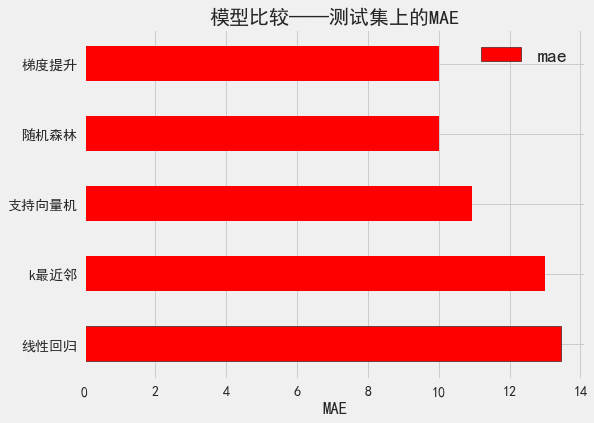

In [23]:
plt.style.use('fivethirtyeight')
figsize(8, 6)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 保存结果
model_comparison = pd.DataFrame({'model' : ['线性回归', '支持向量机',
                                           '随机森林', '梯度提升', 'k最近邻'],
                                'mae' : [lr_mae, svm_mae,
                                        random_forest_mae, gradient_boosted_mae, knn_mae]})
# 测试集上MAE的水平条形图
model_comparison.sort_values('mae', ascending=False).plot(x='model', y='mae', kind='barh',
                                                         color='red', edgecolor='black')
# 绘图格式
plt.ylabel('')
plt.yticks(size=14)
plt.xlabel('MAE')
plt.xticks(size=14)
plt.title('模型比较——测试集上的MAE', size=20)
# 所有模型都明显优于基线，证明机器学习适用于该项目
# 梯度提升和随机森林表现最佳

# Model Optimization
为特定问题找到**最佳的超参数集**。
## Hyperparameters
* 模型**超参数**是机器学习算法的设置，在训练之前由数据科学家调整。例如，随机森林中的树数量，或者K近邻中使用的邻居数量。

* 模型**参数**是模型在训练期间学习的内容，例如线性回归中的权重。

调整模型超参数可以控制模型中**欠拟合**与**过拟合**的平衡。

通过**更复杂的模型**来校正**欠拟合**，例如在随机森林中使用更多树或在深度神经网络中使用更多层。不合适的模型没有足够的容量（自由度）来学习特征和目标之间的关系，该模型具有**高偏差**。

通过**限制模型的复杂性**和应用**正则化**来尝试纠正**过拟合**。这可能会降低多项式回归的程度，或将随机失活（**dropout**）层添加到深度神经网络。过拟合的模型具有**高方差**并且实际上记住了训练集。

欠拟合和过拟合会导致在测试集上**泛化能力**差。

## Hyperparameter Tuning with Random Search and Cross Validation
* **随机搜索**是指**选择超参数**来评估的方法：定义一系列选项，然后随机选择要尝试的组合。这与网格搜索形成对比，网格搜索评估指定的每个组合。对最佳模型超参数的知识有限时，随机搜索会更好，可以使用随机搜索**缩小选项范围**，然后使用更有限的选项范围进行**网格搜索**。

* **交叉验证**是用于**评估超参数性能**的方法。使用**K-Fold交叉验证**，而不是将训练设置拆分为单独的训练集和验证集，这会减少可以使用的训练数据量。将训练集划分为K个Fold，然后进行迭代过程，首先在Fold的K-1上进行训练，然后评估第k个Fold的性能。重复这个过程K次，所以最终将测试训练数据中的每个例子，关键是每次迭代都在测试没有训练过的数据。在K-Fold交叉验证结束时，将**K次迭代的平均误差**作为最终性能度量，然后立即在所有训练数据上训练模型。然后，记录的性能用于比较超参数的不同组合。

**交叉验证（k=5）:**
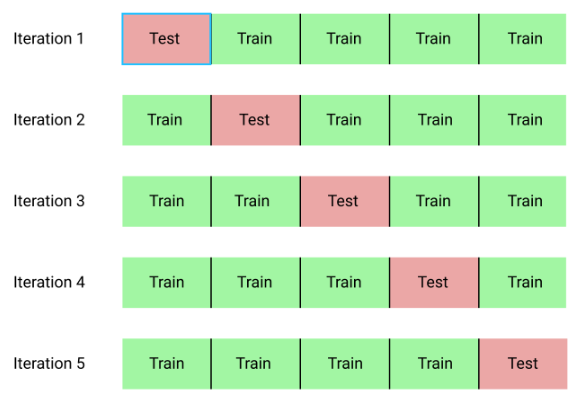

使用交叉验证和随机搜索，选择梯度提升回归的最佳超参数。 首先定义一个网格然后执行迭代过程：从网格中随机抽样一组超参数，使用4-fold交叉验证评估超参数，然后选择具有最佳性能的超参数。

In [25]:
# 优化的损失函数：最小二乘误差，最小绝对误差，Huber损失函数
loss = ['ls', 'lad', 'huber']
# 提升处理中树的数量
n_estimators = [100, 500, 900, 1100, 1500]
# 每个树的最大深度
max_depth = [2, 3, 5, 10, 15]
# 每片树叶样本的最小数量
min_samples_leaf = [1, 2, 4, 6, 8]
# 用于分割节点的样本的最小数量
min_samples_split = [2, 4, 6, 10]
# 分割时考虑的特征的最大数量
max_features = ['auto', 'sqrt', 'log2', None]
# 定义用于搜索的超参数网格
hyperparameter_grid = {'loss' : loss,
                       'n_estimators' : n_estimators,
                       'max_depth' : max_depth,
                       'min_samples_leaf' : min_samples_leaf,
                       'min_samples_split' : min_samples_split,
                       'max_features' : max_features}

随机化搜索，传递以下参数：
* **estimator**: 模型
* **param_distributions**: 定义参数分布（超参数网格）
* **cv**: k-fold交叉验证的fold数量
* **n_iter**: 尝试不同组合的数量
* **scoring**: 评估候选组合的指标
* **n_jobs**: 并行运行的核心数（-1将使用所有可用的核心）
* **verbose**: 要显示多少信息（1显示有限数量）
* **return_train_score**: 返回每个交叉验证fold的训练分数
* **random_state**: 修复了使用的随机数生成器，因此每次运行都会得到相同的结果

In [26]:
# 创建模型，用于超参数调整
model = GradientBoostingRegressor(random_state = 42)
# 创建随机搜索和4-fold交叉验证
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4,
                               n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1,
                               verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [27]:
# 训练数据
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.3min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [28]:
# 获取所有cv结果并按测试性能排序
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
12,24.177750,0.041255,-8.998761,-6.893790,lad,5,None,6,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",1,-8.859381,-7.027368,-8.773966,-6.837958,-9.325139,-6.869084,-9.036779,-6.840749,0.371686,0.011780,0.210901,0.078077
3,19.637780,0.030000,-9.041004,-4.465253,huber,5,None,8,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",2,-8.868788,-4.482073,-8.904791,-4.326121,-9.315304,-4.823009,-9.075321,-4.229809,0.458624,0.001874,0.176509,0.225313
9,13.711516,0.025249,-9.192518,-6.987506,huber,3,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",3,-9.134318,-7.007604,-9.042461,-7.088986,-9.441179,-6.913108,-9.152240,-6.940327,0.333166,0.000435,0.149456,0.067939
0,3.127665,0.008997,-9.196413,-7.293554,ls,5,auto,6,2,100,"{'n_estimators': 100, 'min_samples_split': 2, ...",4,-9.101610,-7.302003,-9.026912,-7.312645,-9.456259,-7.173397,-9.201033,-7.386171,0.126985,0.002119,0.162211,0.076569
7,9.683006,0.021746,-9.350555,-7.073741,ls,3,auto,6,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",5,-9.146159,-7.089709,-9.199358,-7.103749,-9.699696,-7.021418,-9.357220,-7.080088,0.271487,0.000834,0.215966,0.031358
10,113.229803,0.161131,-9.376652,-0.400401,huber,10,None,6,10,1100,"{'n_estimators': 1100, 'min_samples_split': 10...",6,-9.261256,-0.378166,-9.243867,-0.459465,-9.528538,-0.393491,-9.473096,-0.370483,3.315032,0.014862,0.125816,0.035092
19,28.681315,0.043249,-9.381693,-8.202307,lad,3,auto,2,6,1100,"{'n_estimators': 1100, 'min_samples_split': 6,...",7,-9.379335,-8.311796,-9.382576,-8.658903,-9.473980,-7.820534,-9.290880,-8.017995,0.825542,0.002388,0.064740,0.316303
2,63.844714,0.065751,-9.419115,-0.165987,huber,10,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",8,-9.385744,-0.164859,-9.288317,-0.193613,-9.572674,-0.164415,-9.429825,-0.141062,2.013910,0.004084,0.102366,0.018629
16,40.778873,0.074501,-9.446787,-4.801009,ls,3,None,6,4,1500,"{'n_estimators': 1500, 'min_samples_split': 4,...",9,-9.246573,-4.821677,-9.317156,-4.876202,-9.798950,-4.776650,-9.424668,-4.729506,0.222984,0.004558,0.212942,0.054284
21,8.634252,0.042003,-9.460295,-5.666205,huber,5,log2,4,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",10,-9.393840,-5.684121,-9.289175,-5.742441,-9.750806,-5.571781,-9.407503,-5.666476,0.267518,0.004184,0.173829,0.061337


In [29]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

最佳梯度提升模型的超参数值如下:
* loss = lad
* n_estimators = 500
* max_depth = 5
* min_samples_leaf = 6
* min_samples_split = 6
* max_features = None(n_features)